<a href="https://colab.research.google.com/github/Uditsingh7/Machine_Learning_Projects/blob/main/Logistic_Regression_Project_Telco_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Title**

# Telco Customer Churn Prediction with Logistic Regression

**Business Problem & Objective**
Churn is when a customer stops using a /telco service. The goal is to predict whether a customer will churn in the next month using demographic, account, and service features so the business can proactively retain at-risk customers.

**Success criteria:**

Build a Logistic Regression model with strong recall/ROC-AUC for the “Churn” class.

Provide interpretable coefficients to inform retention actions.

Package the final model with a reproducible pipeline and a minimal API for serving predictions.

**Dataset**: “WA_Fn-UseC_-Telco-Customer-Churn.csv” from IBM/Kaggle with 7,043 rows and 21 columns; target column “Churn”

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/blastchar/telco-customer-churn")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: uditsinghthakur
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn


100%|██████████| 172k/172k [00:00<00:00, 265MB/s]

In [2]:
# @title Setup
# Install (if needed) in notebook environment
# !pip install pandas numpy scikit-learn matplotlib seaborn joblib fastapi uvicorn

import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from joblib import dump, load

sns.set(style="whitegrid", context="notebook")
pd.set_option("display.max_columns", 100)


In [3]:
# @title Data Loading

DATA_PATH = "/content/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# @title Quick Data Overview
print(df.shape)
print(df.columns.tolist())
df.info()
df.describe(include="all").T

(7043, 21)
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   ob

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


**Notes:**

Target is “Churn” (Yes/No).

Common columns include customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, InternetService, Contract, PaymentMethod, MonthlyCharges, TotalCharges, etc..

In [6]:
# @title Problem Framing and Target

TARGET = "Churn"
# Convert target to binary: Yes -> 1, No -> 0
df[TARGET] = df[TARGET].map({"Yes": 1, "No": 0})
df[TARGET].value_counts(normalize=True)


,proportion
Churn,
0,0.73463
1,0.26537


**Business note:** Expect class imbalance (more non-churners); consider class_weight or threshold tuning to improve recall if that’s a business priority.

In [9]:
# @title Data Cleaning and Preprocessing Plan

**Key steps:**

Drop identifier: customerID.

Fix TotalCharges type (may have spaces/empty strings) and convert to numeric.

Split train/test with stratification on Churn.

Impute missing values.

One-hot encode categorical features.

Scale numeric features.

Use a single scikit-learn Pipeline for reproducibility and portability.

In [7]:
# Drop unique identifier
if "customerID" in df.columns:
    df.drop(columns=["customerID"], inplace=True)

# Clean TotalCharges: some rows may have spaces; coerce to numeric
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    df.dropna(subset=["TotalCharges"], inplace=True)

# Train-Test Split

X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify feature types
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_features, categorical_features


(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'])

In [8]:
# @title Preprocessing Pipelines

# Numeric features: fill missing values with median, then scale to standard normal
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace NaNs with the median of the column
    ("scaler", StandardScaler())                   # Scale features to mean=0 and std=1
])

# Categorical features: fill missing values with most frequent category, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),           # Replace NaNs with the most common category
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # Convert categories to binary columns, ignore unseen categories in test data
])

# Combine numeric & categorical transformations into a single preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),  # Apply numeric pipeline to numeric columns
        ("cat", categorical_transformer, categorical_features),  # Apply categorical pipeline to categorical columns
    ],
    remainder="drop"  # Drop any columns not specified in numeric_features or categorical_features
)


In [18]:
# @title Exploratory Data Analysis (EDA)
# Understand distributions, relationships, and churn drivers.

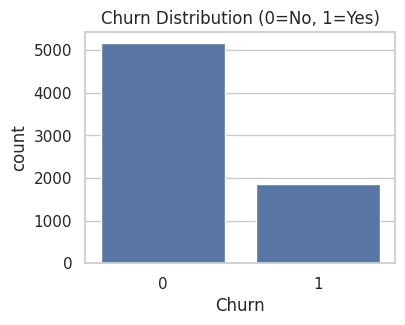

In [9]:
# Target distribution
fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(x=y, ax=ax)
ax.set_title("Churn Distribution (0=No, 1=Yes)")
plt.show()

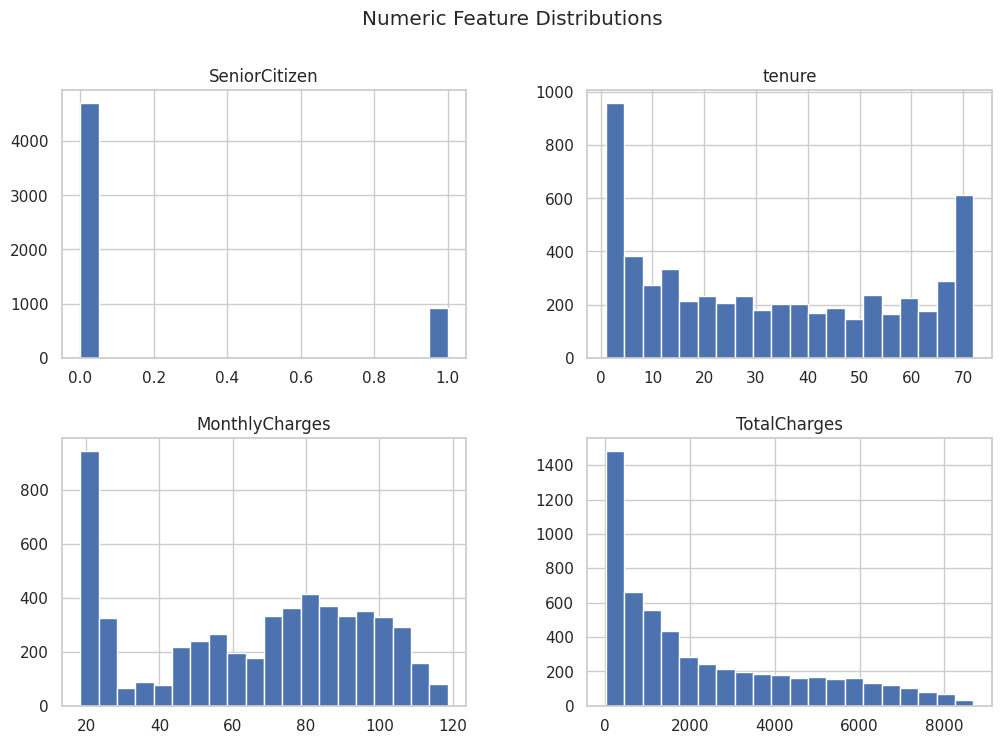

In [10]:
# Numeric distributions
X_train[numeric_features].hist(bins=20, figsize=(12,8))
plt.suptitle("Numeric Feature Distributions")
plt.show()

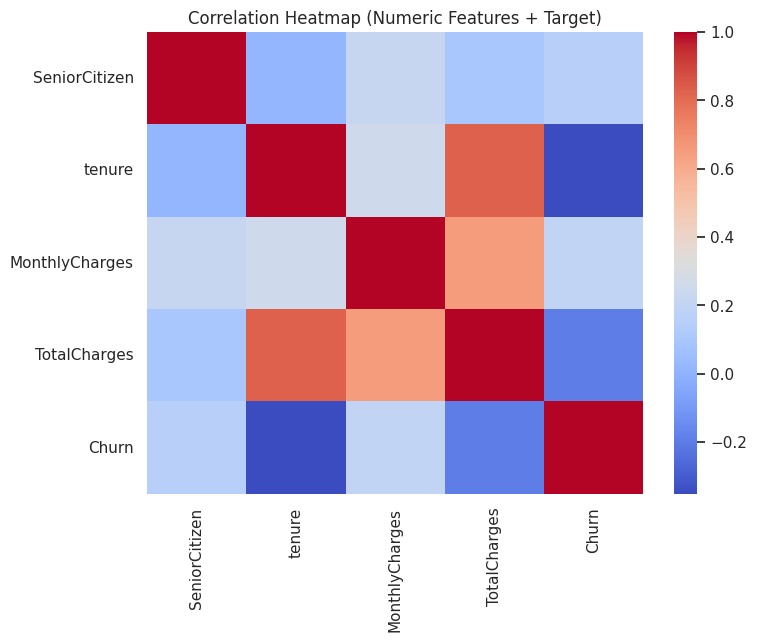

In [11]:
# Correlation heatmap for numeric features
plt.figure(figsize=(8,6))
sns.heatmap(pd.concat([X_train[numeric_features], y_train], axis=1).corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features + Target)")
plt.show()


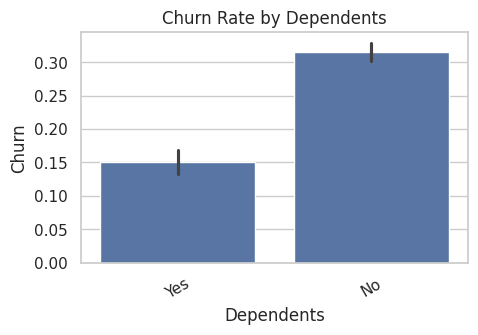

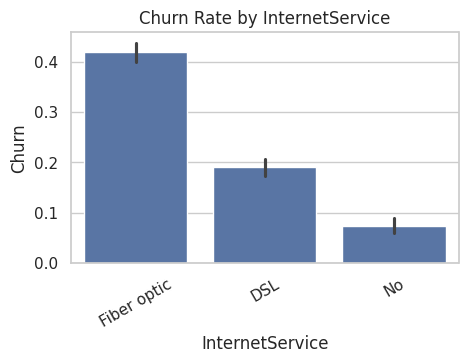

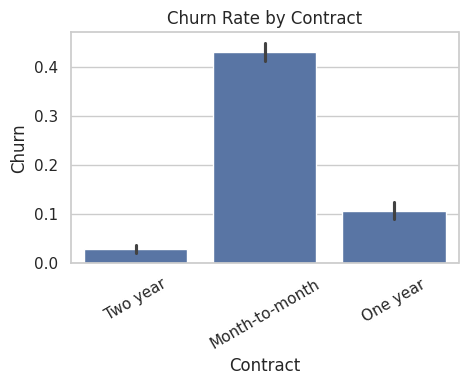

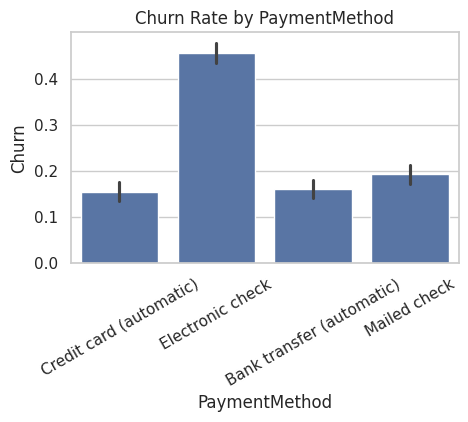

In [12]:
# Churn rate by selected categorical features
selected_cats = [c for c in categorical_features if c in ["Contract", "InternetService", "PaymentMethod", "Dependents"]]
for col in selected_cats:
    plt.figure(figsize=(5,3))
    sns.barplot(x=col, y=TARGET, data=pd.concat([X_train[[col]], y_train], axis=1), estimator=np.mean)
    plt.title(f"Churn Rate by {col}")
    plt.xticks(rotation=30)
    plt.show()

In [13]:
# @title Baseline Logistic Regression (Default Parameters)
# Create a baseline classification pipeline
baseline_clf = Pipeline(steps=[
    # Step 1: Data preprocessing
    ("preprocess", preprocessor),
    # This will handle missing values, scaling for numeric features,
    # and encoding for categorical features (defined earlier).

    # Step 2: Logistic Regression model
    ("model", LogisticRegression(max_iter=1000, random_state=42))
    # LogisticRegression → a simple but strong baseline model for binary classification.
    # max_iter=1000 → allows more iterations for the optimizer to converge (default is often too low).
    # random_state=42 → fixes randomness for reproducibility.
    # Default settings: L2 regularization (penalty='l2'), solver='lbfgs' (good for small/medium datasets).
])

# Train (fit) the model on the training set
baseline_clf.fit(X_train, y_train)

# Make predictions on the test set (hard classification: 0 or 1)
y_pred = baseline_clf.predict(X_test)

# Get predicted probabilities for the positive class (column index 1)
y_proba = baseline_clf.predict_proba(X_test)[:, 1]
# predict_proba returns two columns: [probability of class 0, probability of class 1].
# We take [:, 1] to get probabilities of class 1 (positive outcome).

# Calculate baseline performance metrics
baseline_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),        # % of correct predictions
    "precision": precision_score(y_test, y_pred),      # Out of predicted positives, how many were actually positive
    "recall": recall_score(y_test, y_pred),            # Out of actual positives, how many did we correctly identify
    "f1": f1_score(y_test, y_pred),                    # Harmonic mean of precision and recall
    "roc_auc": roc_auc_score(y_test, y_proba),         # Area under ROC curve, measures ranking quality
}

# Display metrics dictionary
baseline_metrics


{'accuracy': 0.8038379530916845,
 'precision': 0.6484848484848484,
 'recall': 0.5721925133689839,
 'f1': 0.6079545454545454,
 'roc_auc': np.float64(0.8359290473207676)}

**Model Improvement with Regularization (L1/L2)**

Regularization helps control overfitting; L1 yields sparse coefficients (feature selection), L2 stabilizes weights. Solver compatibility matters: L1 works with liblinear/saga, L2 with lbfgs/liblinear/saga.

We’ll tune:

C (inverse regularization strength; smaller C = stronger regularization)

penalty in ['l1','l2'] with corresponding solver choices

In [14]:
# Create a Logistic Regression model instance
# - max_iter=2000: Maximum number of iterations for solver to converge (default 100 often too low for complex data)
# - class_weight="balanced": Automatically adjust weights inversely proportional to class frequencies to handle class imbalance
# - random_state=42: Seed for reproducibility so results are consistent across runs
log_reg = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)

# Build a pipeline that:
# 1. Preprocesses the data (scaling, encoding, imputing)
# 2. Trains the logistic regression model
pipe = Pipeline(steps=[
    ("preprocess", preprocessor),  # Preprocessor from earlier (handles numeric + categorical features)
    ("model", log_reg)             # Logistic regression model as the final step
])

# Grid search parameter space:
# Each dictionary in the list is a separate parameter search space
# Different solvers support different penalties:
# - L1 regularization: good for feature selection, requires solver='liblinear' or 'saga'
# - L2 regularization: common default, works with solver='lbfgs', 'liblinear', or 'saga'
param_grid = [
    {
        "model__penalty": ["l1"],                 # L1 penalty (Lasso-like effect)
        "model__solver": ["liblinear"],           # 'liblinear' works well for small/medium datasets and supports L1
        "model__C": [0.01, 0.1, 1.0, 10.0]         # Inverse of regularization strength; lower = stronger regularization
    },
    {
        "model__penalty": ["l2"],                 # L2 penalty (Ridge-like effect)
        "model__solver": ["lbfgs"],               # 'lbfgs' efficient for larger datasets and supports only L2
        "model__C": [0.01, 0.1, 1.0, 10.0]         # Same regularization parameter range
    }
]

# GridSearchCV: Try all combinations in param_grid with cross-validation
# - estimator=pipe: The pipeline that will be tuned
# - scoring="roc_auc": Use ROC AUC as the metric (good for imbalanced classification)
# - cv=5: 5-fold cross-validation
# - n_jobs=-1: Use all available CPU cores for speed
# - verbose=1: Print progress information
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on training data
grid.fit(X_train, y_train)

# Get best parameters and score
best_params = grid.best_params_
best_score = grid.best_score_

# Print in a clear format
print("Best Parameters Found:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation ROC AUC Score: {best_score:.4f}")



Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters Found:
  model__C: 10.0
  model__penalty: l1
  model__solver: liblinear

Best Cross-Validation ROC AUC Score: 0.8458


**Notes:**

class_weight="balanced" helps when target is imbalanced to improve recall/ROC-AUC.

Choice of compatible solver/penalty per scikit-learn docs is critical to avoid errors

In [15]:
# @title Evaluate the Tuned Model on the Test Set

# Retrieve the best model from grid search
best_clf = grid.best_estimator_

# Predictions on the test set
y_pred_best = best_clf.predict(X_test)  # Predicted class labels
y_proba_best = best_clf.predict_proba(X_test)[:, 1]  # Predicted probabilities for ROC-AUC

# Compute key evaluation metrics
metrics = {
    "accuracy": accuracy_score(y_test, y_pred_best),
    "precision": precision_score(y_test, y_pred_best),
    "recall": recall_score(y_test, y_pred_best),
    "f1": f1_score(y_test, y_pred_best),
    "roc_auc": roc_auc_score(y_test, y_proba_best),
}

# Display the results
print("Best Hyperparameters:", grid.best_params_)
print("Best CV ROC-AUC Score:", grid.best_score_)
print("Test Set Metrics:", json.dumps(metrics, indent=2))

# Detailed class-wise performance
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_best, digits=4))


Best Hyperparameters: {'model__C': 10.0, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best CV ROC-AUC Score: 0.8457882206224137
Test Set Metrics: {
  "accuracy": 0.7249466950959488,
  "precision": 0.48932676518883417,
  "recall": 0.7967914438502673,
  "f1": 0.6063072227873856,
  "roc_auc": 0.834539087130056
}

Classification Report:

              precision    recall  f1-score   support

           0     0.9048    0.6989    0.7886      1033
           1     0.4893    0.7968    0.6063       374

    accuracy                         0.7249      1407
   macro avg     0.6970    0.7479    0.6975      1407
weighted avg     0.7943    0.7249    0.7402      1407



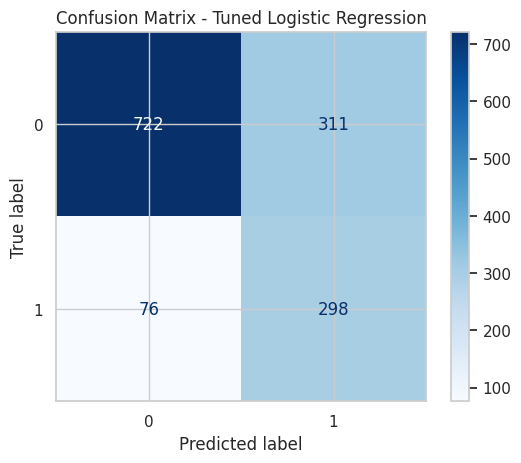

In [16]:
# @title Confusion Matrix and ROC Curve

# ========================
# CONFUSION MATRIX SECTION
# ========================

# A confusion matrix is a table that shows how well a classification model
# is performing by comparing actual labels vs predicted labels.
# It breaks down predictions into 4 categories:
#  - True Positive (TP): Correctly predicted "Yes" (churned customers predicted as churned)
#  - True Negative (TN): Correctly predicted "No" (non-churned customers predicted as non-churned)
#  - False Positive (FP): Incorrectly predicted "Yes" (non-churned predicted as churned)
#  - False Negative (FN): Incorrectly predicted "No" (churned predicted as non-churned)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the confusion matrix using actual test labels and predicted labels
cm = confusion_matrix(y_test, y_pred_best)

# Display the confusion matrix visually as a colored grid
# - display_labels: The actual class names (e.g., ["No Churn", "Churn"])
# - values_format="d": Show whole numbers instead of decimals
# - cmap="Blues": Use a blue color map
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=best_clf.named_steps["model"].classes_
)
disp.plot(values_format="d", cmap="Blues")

# Add a title to the plot
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.show()



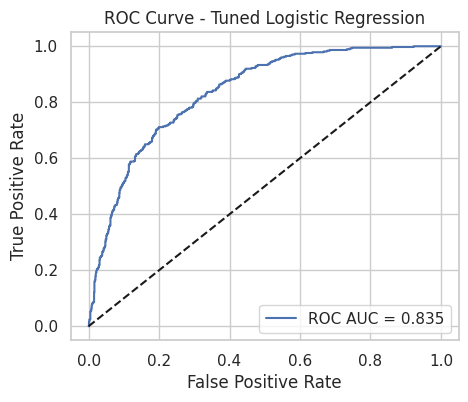

In [17]:
# ========================
# ROC CURVE SECTION
# ========================

# ROC (Receiver Operating Characteristic) curve shows the trade-off between
# the True Positive Rate (TPR) and False Positive Rate (FPR) at different thresholds.
# Definitions:
#   - TPR (Recall or Sensitivity) = TP / (TP + FN)
#   - FPR = FP / (FP + TN)
# The curve helps us see how well the model separates the two classes.
# A perfect model has a curve that hugs the top-left corner.
# The diagonal line is a "random guess" baseline.

from sklearn.metrics import roc_curve, roc_auc_score

# Generate FPR, TPR, and thresholds from the predicted probabilities
# y_proba_best are probability scores for the positive class ("Churn")
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)

plt.figure(figsize=(5,4))

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba_best):.3f}")

# Plot a dashed diagonal line representing random guessing
plt.plot([0,1], [0,1], "k--")

# Label axes
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Title and legend
plt.title("ROC Curve - Tuned Logistic Regression")
plt.legend(loc="lower right")
plt.show()

# ========================
# EXTRA DEFINITION:
# ========================
# AUC (Area Under the Curve):
#   - The ROC AUC score measures how well the model distinguishes between classes.
#   - Range: 0.5 (random guessing) to 1.0 (perfect classifier).
#   - Higher AUC = better model performance.


In [18]:
# @title Interpretability: Coefficients and Feature Importance

# For interpretability, extract the pipeline’s one-hot feature names and pair with coefficients.
# Positive coefficients increase churn odds; negative decrease.


# Why: This function retrieves the final list of feature names after preprocessing
#      so we can match them with the model's coefficients.
#      - Numeric features keep their original names.
#      - Categorical features get expanded into multiple columns after one-hot encoding (OHE),
#        so we must extract those expanded column names.
def get_feature_names(preprocessor, numeric_features, categorical_features):
    # Numeric feature names stay the same after preprocessing
    num_names = numeric_features

    # Retrieve the fitted OneHotEncoder from the categorical transformer pipeline
    ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]

    # Get expanded categorical feature names (e.g., "Gender_Female", "Gender_Male")
    cat_names = ohe.get_feature_names_out(categorical_features).tolist()

    # Combine numeric and categorical feature names into one list
    return num_names + cat_names


# Why: Extract the feature names from the preprocessing pipeline of the best model
#      so we can align them with the logistic regression coefficients.
feature_names = get_feature_names(
    best_clf.named_steps["preprocess"],
    numeric_features,
    categorical_features
)

# Why: Retrieve the learned coefficients from the logistic regression model
#      (one coefficient per feature).
coefs = best_clf.named_steps["model"].coef_.ravel()

# Create a DataFrame to pair feature names with their coefficients
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs
})

# Add a column with absolute coefficient values
# Why: Sorting by absolute value lets us see which features have the strongest influence,
#      regardless of whether the relationship is positive or negative.
coef_df["abs_coef"] = coef_df["coef"].abs()

# Sort features by absolute coefficient strength (descending)
coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)

# Display the top 15 most impactful features
coef_df_sorted.head(15)




,feature,coef,abs_coef
2,MonthlyCharges,-1.755982,1.755982
38,Contract_Two year,-1.341656,1.341656
1,tenure,-1.286195,1.286195
34,StreamingMovies_No internet service,-1.167216,1.167216
15,InternetService_DSL,-1.117353,1.117353
16,InternetService_Fiber optic,1.068639,1.068639
32,StreamingTV_Yes,0.792590,0.792590
37,Contract_One year,-0.648015,0.648015
3,TotalCharges,0.646584,0.646584
25,DeviceProtection_No internet service,-0.502318,0.502318


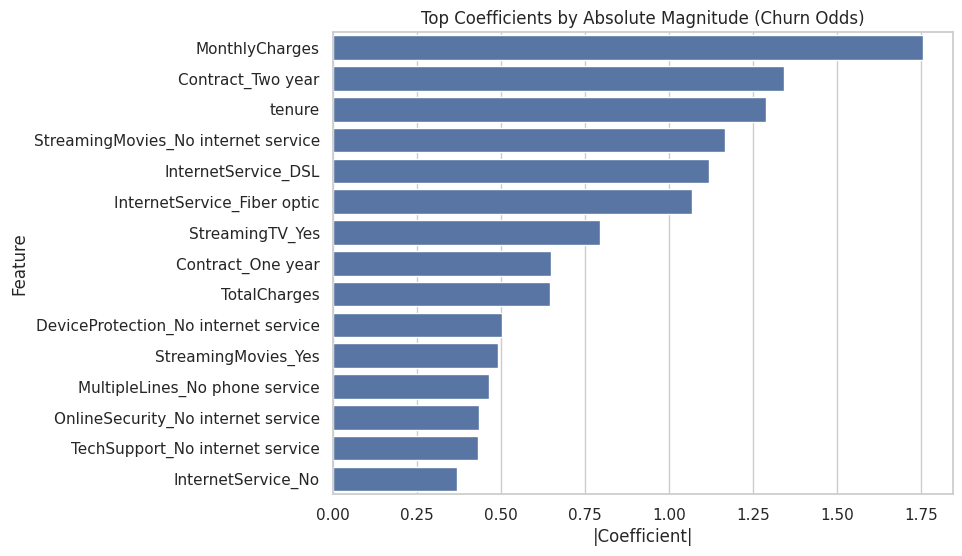

In [19]:
top_n = 15
plt.figure(figsize=(8,6))
sns.barplot(
    data=coef_df_sorted.head(top_n),
    x="abs_coef",
    y="feature",
    hue=None,
    orient="h"
)
plt.title("Top Coefficients by Absolute Magnitude (Churn Odds)")
plt.xlabel("|Coefficient|")
plt.ylabel("Feature")
plt.show()


note: L1 tends to zero-out less informative features, providing built-in feature selection, whereas L2 spreads weight more smoothly for stability

In [21]:
# @title Threshold Tuning (Optional for Business Recall)

# If the business prioritizes catching churners (high recall), adjust decision threshold from default 0.5

# --------------------------------------------
# THRESHOLD TUNING (Optional for Business Recall)
# --------------------------------------------

# WHY:
# 1. A classification model like Logistic Regression outputs probabilities for each class.
#    Example: model predicts "churn" = 0.73 (73% probability).
# 2. By default, we apply a threshold of 0.5:
#       - If probability >= 0.5 → predict "churn" (class 1)
#       - If probability < 0.5 → predict "no churn" (class 0)
# 3. This default 0.5 threshold works when we want to balance false positives and false negatives.
# 4. In business contexts like churn prevention, *recall* (catching as many churners as possible)
#    may be more important than precision.
#    Lowering the threshold increases recall — we predict "churn" even when probability is smaller.
#    However, this can also increase false positives.
# 5. Here, we will experiment with thresholds from 0.2 to 0.8 to see the trade-off between
#    precision, recall, and F1 score.

# Step 1: Define a range of thresholds to evaluate
thresholds = np.linspace(0.2, 0.8, 13)
# np.linspace(start, stop, num_points) → here it creates 13 values evenly spaced between 0.2 and 0.8
# e.g., [0.20, 0.25, 0.30, ..., 0.80]

# Step 2: List to store performance results for each threshold
perf = []

# Step 3: Loop over each threshold and calculate metrics
for thr in thresholds:
    # Convert predicted probabilities (y_proba_best) to binary predictions using current threshold
    # Example: if thr = 0.3, then any probability >= 0.3 is classified as churn (1)
    y_pred_thr = (y_proba_best >= thr).astype(int)

    # Calculate metrics for this threshold
    perf.append({
        "threshold": thr,
        "precision": precision_score(y_test, y_pred_thr),  # % of predicted churners that were correct
        "recall": recall_score(y_test, y_pred_thr),        # % of actual churners we correctly caught
        "f1": f1_score(y_test, y_pred_thr)                  # Balance between precision and recall
    })

# Step 4: Convert results into a DataFrame for easy inspection
perf_df = pd.DataFrame(perf)
print(perf_df)



    threshold  precision    recall        f1
0        0.20   0.388528  0.959893  0.553159
1        0.25   0.398633  0.935829  0.559105
2        0.30   0.415072  0.927807  0.573554
3        0.35   0.430946  0.901070  0.583045
4        0.40   0.450276  0.871658  0.593807
5        0.45   0.474242  0.836898  0.605416
6        0.50   0.489327  0.796791  0.606307
7        0.55   0.513612  0.756684  0.611892
8        0.60   0.541582  0.713904  0.615917
9        0.65   0.572727  0.673797  0.619165
10       0.70   0.612732  0.617647  0.615180
11       0.75   0.642857  0.529412  0.580645
12       0.80   0.688679  0.390374  0.498294


In [22]:
FINAL_MODEL_PATH = "model.pkl"
dump(best_clf, FINAL_MODEL_PATH)
os.path.exists(FINAL_MODEL_PATH), FINAL_MODEL_PATH

(True, 'model.pkl')